# Necessary Imports
In this section, we will import the necessary libraries for training our Random Forest (RF) model. This includes libraries for data manipulation, model building, and evaluation.

In [2]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import joblib
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, log_loss, precision_score, 
    recall_score, f1_score, make_scorer, recall_score
)
from sklearn.utils import class_weight, compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample

# sklearn Model and Hyperparameter Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# tensorFlow and keras model utilities
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# tensorFlow and keras layers
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, 
    Conv2DTranspose, Activation, LeakyReLU, UpSampling2D, 
    Conv2D, MaxPooling2D, ReLU
)

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# regularization
from keras.regularizers import l2
from sklearn.metrics import make_scorer, recall_score


# Image Loading and Preprocessing Functions
We shall create several functions for loading and preprocessing images from a specified directory. The functions perform the following tasks:

1. **Check if a file is an image:** A helper function that determines if a given filename has an image file extension (specifically `.jpg`).

2. **Load and preprocess an image:** A function that loads an image from a specified path, resizes it to a target size (defaulting to 128x128 pixels), normalizes pixel values to be between 0 and 1, and ensures that the image has three color channels (RGB).

3. **Load images from a directory:** A function that walks through a specified directory, loads and preprocesses images, and assigns them a label (either fraudulent or non-fraudulent) based on the provided input.

4. **Set base directory and load training images:** The base directory for the dataset is specified, along with paths to the training data subdirectories for fraudulent and non-fraudulent images. The training images are then loaded and labeled accordingly.

In [4]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [5]:
# function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # load image
    image = Image.open(img_path)
    
    # resize image to target size
    image = image.resize(target_size)
    
    # convert image to array and normalize (pixel values between 0 and 1)
    image = np.array(image) / 255.0
    
    # ensure image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]
    
    return image

In [6]:
# function to load images from a directory and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                img_path = os.path.join(root, file)
                image = load_and_preprocess_image(img_path)  # Load and preprocess
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [7]:
# base directory for the dataset
directory = 'vehicle_insurance_dataset'

# set paths for training data subdirectories
train_fraud_dir = os.path.join(directory, 'train', 'fraud')
train_non_fraud_dir = os.path.join(directory, 'train', 'non-fraud')

# load and label the training images for fraud and non-fraud cases
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


# Denoising Function
We will create a function to load the saved denoising model for processing images using a Deep Convolutional Autoencoder (DCAE). The function performs the following tasks:

1. **Load the DCAE model:** The model is loaded from a specified path to be used for denoising the images.

2. **Denoise fraud and non-fraud images:** The function uses the loaded DCAE model to predict and denoise both fraudulent and non-fraudulent images.

3. **Print shapes of the denoised datasets:** The shapes of the resulting denoised image arrays for both the fraud and non-fraud datasets are printed to provide insight into the transformation.

The function then returns the denoised images for both categories, which can be further utilized in model training or evaluation.

In [9]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    rf_gan_fraud_images_denoised = dcae_model.predict(fraud_images)
    rf_gan_non_fraud_images_denoised = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {rf_gan_fraud_images_denoised.shape}")
    print(f"Denoised Non-Fraud dataset shape: {rf_gan_non_fraud_images_denoised.shape}")

    return rf_gan_fraud_images_denoised, rf_gan_non_fraud_images_denoised

# Load Fraud and Non-Fraud Images from the Train Directories
In this section, the previously loaded training images for fraud and non-fraud cases are assigned to variables for denoising:
- `fraud_images` is set to `train_images_fraud`.
- `non_fraud_images` is set to `train_images_non_fraud`.

In [11]:
# load fraud and non-fraud images from the train directories
fraud_images = train_images_fraud
non_fraud_images = train_images_non_fraud

# Balancing Dataset with GAN-Generated Synthetic Fraud Images
We create a function for balancing the dataset by generating synthetic fraud images using a Generative Adversarial Network (GAN). The function performs the following tasks:

1. **Load the Pre-Trained GAN Model:** The GAN generator model is loaded from a specified path.

2. **Determine the Number of Synthetic Images to Generate:** The function calculates how many synthetic fraud images need to be generated based on the difference in count between non-fraud and fraud images.

3. **Generate Random Noise for GAN Input:** Random noise is created to serve as input for the GAN, assuming the input shape is (100,).

4. **Generate Synthetic Fraud Images:** The GAN generator predicts synthetic fraud images based on the random noise.

5. **Combine Original and Synthetic Fraud Images:** The original fraud images are combined with the newly generated synthetic fraud images.

6. **Create a Balanced Dataset:** The combined fraud images and non-fraud images are stacked together to form a balanced dataset.

7. **Create Labels:** The function generates labels for the balanced dataset, assigning a label of 1 for fraud and 0 for non-fraud.

The function returns the balanced dataset and the corresponding labels.

In [13]:
# function to balance dataset using GAN-generated synthetic fraud images
def balance_dataset_with_gan(fraud_images, non_fraud_images, gan_model_path):
    # load the pre-trained GAN model
    gan_generator = load_model(gan_model_path)
    
    # determine how many synthetic images to generate
    num_synthetic_images = len(non_fraud_images) - len(fraud_images)
    
    # generate random noise for GAN input
    noise = np.random.normal(0, 1, (num_synthetic_images, 100))  # assuming GAN input shape is (100,)
    
    # generate synthetic fraud images
    synthetic_fraud_images = gan_generator.predict(noise)
    
    # combine original fraud images with synthetic fraud images
    combined_fraud_images = np.vstack((fraud_images, synthetic_fraud_images))
    
    # combine fraud and non-fraud images into one balanced dataset
    balanced_images = np.vstack((combined_fraud_images, non_fraud_images))
    
    # create labels (1 for fraud, 0 for non-fraud)
    balanced_train_labels = np.hstack((np.ones(len(combined_fraud_images)), np.zeros(len(non_fraud_images))))
    
    return balanced_images, balanced_train_labels

# Balancing the Dataset Using GAN-Generated Images

To address the class imbalance issue in the dataset, we utilize GAN-generated images to balance the number of fraud and non-fraud images. This process involves generating synthetic fraud images and combining them with the original non-fraud images.

### Steps:
1. **Balancing the Dataset**:
   - We use the `balance_dataset_with_gan` function, which generates synthetic fraud images based on a pre-trained GAN model ('generator_model.keras'). This function ensures that the number of fraud images matches the number of non-fraud images in the dataset.

2. **Calculating the Number of Fraud Images**:
   - The number of fraud images in the balanced dataset is calculated by determining how many fraud images are needed to match the number of non-fraud images. This includes both the original and synthetic fraud images.

3. **Splitting the Balanced Dataset**:
   - The balanced dataset is split into fraud and non-fraud sets:
     - `balanced_fraud_images`: Contains all fraud images (real and synthetic).
     - `balanced_non_fraud_images`: Contains the non-fraud images.

4. **Combining the Images and Labels**:
   - The fraud images (real and synthetic) are concatenated together into `combined_fraud_images`.
   - Labels for the fraud images are set to 1 (`combined_fraud_labels`), while labels for the non-fraud images are set to 0 (`combined_non_fraud_labels`).

In [15]:
# balance the dataset using GAN-generated images
balanced_images, balanced_train_labels = balance_dataset_with_gan(
    fraud_images, non_fraud_images, 'generator_model.keras')

179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 626ms/step


## Data Augmentation Functions

The following functions implement advanced data augmentation techniques to enhance the diversity of the training dataset. These techniques are applied to the images and their corresponding labels:

### 1. **MixUp**
MixUp blends two images and their labels using a randomly sampled weight (lambda factor) from a Beta distribution. This approach helps in creating new, interpolated samples and smooth label transitions.

#### Implementation:
- Randomly shuffle the dataset.
- Use a lambda factor to blend two images and their labels.

### 2. **CutMix**
CutMix replaces a region of an image with a corresponding region from another randomly selected image. The label of the new image is also interpolated based on the replaced region's area.

#### Implementation:
- Randomly shuffle the dataset.
- Cut a random patch from one image and replace the corresponding region in another.
- Adjust the labels based on the area of the patch.

### 3. **Attention CutMix**
This technique is similar to CutMix but incorporates a simple attention-like mechanism to focus on certain areas of the image for augmentation. Regions are selected using a random "attention map."

#### Implementation:
- Similar to CutMix, but with a more targeted region selection.
- Perform patch replacement and label interpolation using the attention-based region.

### Benefits of These Techniques:
- Improve generalization by creating diverse training samples.
- Address class imbalance by augmenting minority classes effectively.
- Regularize the model to prevent overfitting.

In [17]:
# define the augmentation functions
def mixup(images, labels, alpha=0.2):
    # Randomly select two images
    indices = np.random.permutation(len(images))
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    
    # lambda factor for mixing images
    lambda_factor = np.random.beta(alpha, alpha, size=len(images))
    
    # create mixed images and labels
    mixed_images = lambda_factor[:, None, None, None] * images + (1 - lambda_factor[:, None, None, None]) * shuffled_images
    mixed_labels = lambda_factor * labels + (1 - lambda_factor) * shuffled_labels
    
    return mixed_images, mixed_labels

def cutmix(images, labels, alpha=0.2):
    # Randomly select two images
    indices = np.random.permutation(len(images))
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    
    # randomly select a region for cutting
    h, w = images.shape[1], images.shape[2]  
    cut_x = np.random.randint(0, w)
    cut_y = np.random.randint(0, h)
    cut_w = np.random.randint(0, w - cut_x)
    cut_h = np.random.randint(0, h - cut_y)
    
    # perform CutMix
    images[:, cut_y:cut_y + cut_h, cut_x:cut_x + cut_w, :] = shuffled_images[:, cut_y:cut_y + cut_h, cut_x:cut_x + cut_w, :]
    
    # create mixed labels
    lambda_factor = (cut_h * cut_w) / (h * w)
    mixed_labels = lambda_factor * labels + (1 - lambda_factor) * shuffled_labels
    
    return images, mixed_labels

def attn_cutmix(images, labels, alpha=0.2):
    # similar to CutMix but with an "attention" mechanism to select the region to cut
    indices = np.random.permutation(len(images))
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    
    # simulating an "attention map" as a simple random region selection
    h, w = images.shape[1], images.shape[2]
    cut_x = np.random.randint(0, w)
    cut_y = np.random.randint(0, h)
    cut_w = np.random.randint(0, w - cut_x)
    cut_h = np.random.randint(0, h - cut_y)
    
    # perform CutMix with attention-based region selection
    images[:, cut_y:cut_y + cut_h, cut_x:cut_x + cut_w, :] = shuffled_images[:, cut_y:cut_y + cut_h, cut_x:cut_x + cut_w, :]
    
    # create mixed labels
    lambda_factor = (cut_h * cut_w) / (h * w)
    mixed_labels = lambda_factor * labels + (1 - lambda_factor) * shuffled_labels
    
    return images, mixed_labels

## Applying Data Augmentation Techniques

The `augment_data` function serves as a centralized handler to apply different augmentation techniques to the dataset. Depending on the specified technique, it calls the appropriate augmentation function and returns the augmented images and labels.

### Implementation Details:

#### Function: `augment_data`
- **Parameters**:
  - `images`: Input images to augment.
  - `labels`: Corresponding labels for the images.
  - `technique`: Specifies the augmentation method (`"mixup"`, `"cutmix"`, `"attn_cutmix"`, or none).

In [19]:
def augment_data(images, labels, technique="mixup"):
    if technique == "mixup":
        return mixup(images, labels)
    elif technique == "cutmix":
        return cutmix(images, labels)
    elif technique == "attn_cutmix":
        return attn_cutmix(images, labels)
    else:
        return images, labels
    
# wrapper for use in tf.data pipelines
def augment_image_tf(image, label, technique="mixup"):
    """Wrapper function to apply augmentations in TensorFlow pipelines."""
    image = tf.cast(image, tf.float32) / 255.0  # Normalize images
    image, label = tf.numpy_function(func=lambda x, y: augment_data(x, y, technique),
                                     inp=[image, label],
                                     Tout=[tf.float32, tf.float32])

    image.set_shape([128, 128, 3]) 
    label.set_shape([]) 
    return image, label

batch_size = 32
technique = "attn_cutmix"  # choose from "mixup", "cutmix", or "attn_cutmix"

# create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_train_labels))
dataset = dataset.map(lambda x, y: augment_image_tf(x, y, technique), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Splitting Augmented Images into Fraud and Non-Fraud Sets

After applying data augmentation to the GAN-balanced dataset, the augmented images need to be separated into fraud and non-fraud subsets. This ensures the dataset maintains the correct labels and proportions for further processing or training.

### Steps:

1. **Determine Number of Fraud Images**:
   - The number of fraud images (`num_fraud_images`) should match the number of non-fraud images to maintain balance.

2. **Split Augmented Images**:
   - The first `num_fraud_images` samples are assigned as fraud images.
   - The remaining samples are assigned as non-fraud images.

3. **Verify the Integrity of the Splits**:
   - Print the shapes of the `balanced_fraud_images` and `balanced_non_fraud_images` to confirm correct separation and size.


In [21]:
# calculate the number of fraud images (real + synthetic) in the balanced dataset
num_total_fraud_images = len(fraud_images) + (len(balanced_images) - len(non_fraud_images))

# split the balanced dataset into fraud and non-fraud subsets
fraud_indices = np.where(balanced_train_labels == 1)[0]
non_fraud_indices = np.where(balanced_train_labels == 0)[0]

balanced_fraud_images = balanced_images[fraud_indices]
balanced_non_fraud_images = balanced_images[non_fraud_indices]

# Denoising the Balanced Fraud and Non-Fraud Images
We will then denoise the balanced fraud and non-fraud images using the Deep Convolutional Autoencoder (DCAE) model. We call the `denoise_images_with_dcae` function, passing the balanced sets of fraud and non-fraud images along with the path to the saved DCAE model.

The denoised images for both categories will be stored in the following variables:
- `rf_gan_fraud_images_denoised`: Contains the denoised synthetic and real fraud images.
- `rf_gan_non_fraud_images_denoised`: Contains the denoised non-fraud images.

In [23]:
# denoise the balanced fraud and non-fraud images
rf_gan_fraud_images_denoised, rf_gan_non_fraud_images_denoised = denoise_images_with_dcae(
    balanced_fraud_images, 
    balanced_non_fraud_images, 
    'dcae_model.keras'
)

# check the number of denoised fraud and non-fraud images
print(f"Number of denoised fraud images: {len(rf_gan_fraud_images_denoised)}")
print(f"Number of denoised non-fraud images: {len(rf_gan_non_fraud_images_denoised)}")

DCAE model loaded.
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step
Denoised Fraud dataset shape: (6091, 128, 128, 3)
Denoised Non-Fraud dataset shape: (6091, 128, 128, 3)
Number of denoised fraud images: 6091
Number of denoised non-fraud images: 6091


### Preparing the Balanced Dataset for Training

1. **Ensure the Number of Fraud and Non-Fraud Images Match**:
   - Count the number of fraud and non-fraud images after denoising.

2. **Combine the Denoised Images**:
   - Use `np.vstack` to stack fraud and non-fraud images into a single dataset.

3. **Generate Corresponding Labels**:
   - Fraud images are labeled as `1` using `np.ones`.
   - Non-fraud images are labeled as `0` using `np.zeros`.
   - Combine these labels into a single array using `np.concatenate`.

4. **Verify Dataset Shapes Before Shuffling**:
   - Print the shapes of the combined images and labels to ensure they match.

5. **Shuffle the Dataset**:
   - Use `shuffle` to randomize the order of images and their corresponding labels.

6. **Normalize the Images**:
   - Scale the pixel values of all images to the range `[0, 1]` by dividing by `255.0`.

7. **Verify Final Dataset Shapes**:
   - Print the shapes of the normalized and shuffled images and labels to confirm correctness.

In [25]:
# ensure the number of fraud and non-fraud images match
num_fraud_images = len(rf_gan_fraud_images_denoised)
num_non_fraud_images = len(rf_gan_non_fraud_images_denoised)

# combine the images and labels
balanced_images = np.vstack((rf_gan_fraud_images_denoised, rf_gan_non_fraud_images_denoised))

# generate corresponding labels for the images
balanced_train_labels = np.concatenate([
    np.ones(num_fraud_images),  # fraud class label = 1
    np.zeros(num_non_fraud_images)  # non-fraud class label = 0
])

# ensure the shapes match before shuffling
print(f"balanced_images shape: {balanced_images.shape}")
print(f"balanced_train_labels shape: {balanced_train_labels.shape}")

# shuffle the dataset
balanced_images, balanced_train_labels = shuffle(balanced_images, balanced_train_labels, random_state=42)

# normalize the final balanced images to [0, 1]
balanced_images = balanced_images / 255.0

# verify dataset shapes
print(f"Balanced dataset shape: {balanced_images.shape}")
print(f"Labels shape: {balanced_train_labels.shape}")

balanced_images shape: (12182, 128, 128, 3)
balanced_train_labels shape: (12182,)
Balanced dataset shape: (12182, 128, 128, 3)
Labels shape: (12182,)


# Flatten the Images for Random Forest
We flatten the images to prepare them for the Random Forest model:

- **`X_flat`**: Reshape the denoised images from the GAN dataset into a 2D array where each image is represented as a single row.
- **`y_flat`**: Use the corresponding training labels.

Prepare the training data by assigning the flattened image data and labels to **`X_train_flat`** and **`y_train_flat`**, respectively. This allows us to utilize the full dataset without any test split.

In [27]:
# flatten the images for Random Forest
X_flat = balanced_images.reshape(balanced_images.shape[0], -1)
y_flat = balanced_train_labels

# class distribution before splitting
print("Class distribution before splitting:", Counter(y_flat))

# split the dataset into training and test sets
X_train_flat, X_val_flat, y_train_flat, y_val_flat = train_test_split(
    X_flat, y_flat, test_size=0.2, random_state=42, stratify=y_flat)

# class distribution after splitting
print("Training labels distribution after splitting:", Counter(y_train_flat))
print("Validation labels distribution after splitting:", Counter(y_val_flat))

Class distribution before splitting: Counter({1.0: 6091, 0.0: 6091})
Training labels distribution after splitting: Counter({1.0: 4873, 0.0: 4872})
Validation labels distribution after splitting: Counter({0.0: 1219, 1.0: 1218})


### Applying Feature Scaling

The following code uses `StandardScaler` from the `sklearn.preprocessing` module to standardize the feature values:

- **Purpose**: 
  - Feature scaling is applied to ensure that the input features have a mean of 0 and a standard deviation of 1. This helps many machine learning algorithms (e.g., Random Forest, PCA) perform better by eliminating biases due to differing feature magnitudes.

- **Steps**:
  1. **Fit and Transform the Training Set**:
     - `scaler.fit_transform(X_train_flat)`: Computes the mean and standard deviation on the training data and scales it accordingly.
  2. **Transform the Validation Set**:
     - `scaler.transform(X_val_flat)`: Uses the same scaling parameters (mean and standard deviation) computed from the training data to scale the validation data.

In [29]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)

# Random Forest Hyperparameter Tuning with GridSearchCV

## Overview:
This section focuses on optimizing the Random Forest classifier using `GridSearchCV`. By exploring a range of hyperparameter values, we aim to identify the configuration that yields the best model performance.

### Preprocessing:
- **Principal Component Analysis (PCA)**: 
  - Applied to reduce dimensionality and retain the most significant features.
  - Training and validation datasets are transformed into a lower-dimensional space with 50 components.

### Random Forest Model:
- **Initialization**:
  - A Random Forest model is initialized with a fixed random state for reproducibility.
- **Parameter Grid**:
  - `n_estimators`: Number of decision trees in the forest.
  - `max_depth`: Maximum depth of each tree.
  - `min_samples_split`: Minimum samples required to split an internal node.
  - `min_samples_leaf`: Minimum samples required to form a leaf node.
  - `max_features`: Number of features to consider for splitting.

### RandomSearchCV:
- **5-Fold Cross-Validation**: Ensures reliable model evaluation by splitting data into training and validation folds.
- **Scoring Metric**: F1 score is used to balance precision and recall.

### Results:
- Displays the best hyperparameters and the corresponding cross-validation F1 score.
- Evaluates the best model on the validation dataset using a confusion matrix and classification report.

### Model Saving:
- The best Random Forest model and PCA are saved together in a file (`rf_gan_with_pca_.pkl`) for future use.

In [46]:
# apply PCA
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)  # fit and transform on training data
X_val_pca = pca.transform(X_val_flat)         # transform validation data

# define and train the Random Forest model
class_weight = {0: 1.0, 1: 15}
rf_classifier = RandomForestClassifier(random_state=42, class_weight=class_weight)

# hyperparameter grid to search
param_distributions = {
    'n_estimators': [25, 50, 75, 100, 150],          # number of trees
    'max_depth': [10, 20, 30, None],                # maximum depth of trees
    'min_samples_split': [2, 5, 10],                # minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],                  # minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],                # number of features to consider for splitting
    'bootstrap': [True, False],               # bootstrap sampling
    'criterion': ['gini', 'entropy'],         # split criterion
}

# custom scoring for minority class recall
scoring = {'recall': 'recall', 'pr_auc': 'average_precision'}

# setup RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=20,  # number of parameter settings to sample
    cv=5,
    n_jobs=1,
    verbose=1,
    scoring=scoring,
    refit='recall',  # use recall as the metric to refit the best model
    random_state=42
)

# fit the model on the training data
random_search.fit(X_train_pca, y_train_flat)

# display best hyperparameters and performance
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Cross-Validation Recall Score: ", random_search.best_score_)

# evaluate the model with best hyperparameters on the validation set
best_rf_classifier = random_search.best_estimator_
y_val_pred = best_rf_classifier.predict(X_val_pca)

# print evaluation metrics
print("Confusion Matrix (Validation):\n", confusion_matrix(y_val_flat, y_val_pred))
print("Classification Report (Validation):\n", classification_report(y_val_flat, y_val_pred))

# save PCA and Random Forest together
joblib.dump({'rf_classifier': best_rf_classifier, 'pca': pca}, 'rf_gan_with_pca_.pkl')
print("Random Forest and PCA saved as rf_gan_with_pca_.pkl")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters:  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Best Cross-Validation Recall Score:  0.9622380877165272
Confusion Matrix (Validation):
 [[1061  158]
 [  40 1178]]
Classification Report (Validation):
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      1219
         1.0       0.88      0.97      0.92      1218

    accuracy                           0.92      2437
   macro avg       0.92      0.92      0.92      2437
weighted avg       0.92      0.92      0.92      2437

Random Forest and PCA saved as rf_gan_with_pca_.pkl


# Loading Test Images and Labels
Here we define the paths to the test directories containing the fraud and non-fraud images. We then load and label the test images using the `load_images_from_directory` function, which retrieves the images from the specified directories and assigns the corresponding labels (1 for fraud and 0 for non-fraud).

### Test Directory Paths:
- **Fraud Images:** Path to the directory containing test fraud images.
- **Non-Fraud Images:** Path to the directory containing test non-fraud images.

In [48]:
# set paths to the test directories
test_fraud_dir = os.path.join(directory, 'test','fraud')
test_non_fraud_dir = os.path.join(directory,'test', 'non-fraud')

# load and label the test images
test_images_fraud, test_labels_fraud = load_images_from_directory(test_fraud_dir, 1)
test_images_non_fraud, test_labels_non_fraud = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {test_images_fraud.shape}")
print(f"Test fraud labels shape: {test_labels_fraud.shape}")

print(f"Test images non_fraud shape: {test_images_non_fraud.shape}")
print(f"Test non_fraud labels shape: {test_labels_non_fraud.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


# Combining and Shuffling Test Images and Labels
In this step, we combine the test images and labels from both the fraud and non-fraud categories into single arrays. This ensures that we have a unified dataset for testing the model. 

### Steps:
1. **Concatenate Test Images and Labels:** The fraud and non-fraud images and their respective labels are concatenated along the first axis.
2. **Shuffle the Data:** To prevent any bias during testing, we generate an array of indices representing the sample positions and shuffle these indices randomly.
3. **Reorder Images and Labels:** The images and labels are reordered based on the shuffled indices to ensure a randomized test set.

In [49]:
# combine the test images and labels
test_images = np.concatenate((test_images_fraud, test_images_non_fraud), axis=0)
test_labels = np.concatenate((test_labels_fraud, test_labels_non_fraud), axis=0)

# shuffle the test data randomly to prevent bias during testing
indices = np.arange(test_images.shape[0])  # Generate an array of indices
np.random.shuffle(indices)  # Shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
test_images = test_images[indices]
test_labels = test_labels[indices]

print(f"Combined test images: {test_images.shape}")
print(f"Combined test labels: {test_labels.shape}")

Combined test images: (1616, 128, 128, 3)
Combined test labels: (1616,)


# Test Image Classification using Pre-Trained Random Forest Model

## Procedure:
1. **Load the Model:**
   - Load the Random Forest classifier and PCA transformation from the saved file `rf_gan_with_pca.pkl`.
   - Verify successful loading of the model and PCA.

2. **Data Preparation:**
   - Flatten the test images into a 2D array where each row corresponds to an image.
   - Apply the PCA transformation to project the flattened images into the reduced-dimensional space.

3. **Prediction:**
   - Use the Random Forest model to predict probabilities (`predict_proba`) and binary labels (`predict`) for the test dataset.

4. **Evaluation Metrics:**
   - **Test Loss**: The log loss calculated using true labels and predicted probabilities.
   - **Test Accuracy**: The proportion of correctly classified samples.
   - **Classification Report**: Includes precision, recall, F1-score, and support for each class.
   - **Confusion Matrix**: A tabular summary showing true positive, true negative, false positive, and false negative counts.

In [50]:
# load saved Random Forest and PCA
saved_objects = joblib.load('rf_gan_with_pca_.pkl')
best_rf_classifier = saved_objects['rf_classifier']
pca = saved_objects['pca']
print("Model and PCA loaded successfully.")

# flatten and transform the test images using the fitted PCA
flattened_test_images = test_images.reshape(test_images.shape[0], -1)  # flatten to shape (num_samples, 128*128*3)
test_images_pca = pca.transform(flattened_test_images)  # apply PCA transformation

# make predictions
predicted_probs = best_rf_classifier.predict_proba(test_images_pca)  # get predicted probabilities
predicted_labels = best_rf_classifier.predict(test_images_pca)

# calculate and print test accuracy
test_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# calculate precision, recall, and F1-score
test_precision = precision_score(test_labels, predicted_labels, zero_division=1)
test_recall = recall_score(test_labels, predicted_labels, zero_division=1)
test_f1 = f1_score(test_labels, predicted_labels, zero_division=1)

# display the metrics
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-Score: {test_f1:.2f}")

# generate and print the classification report and confusion matrix
print("\nClassification Report:\n", classification_report(test_labels, predicted_labels, zero_division=1))
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

Model and PCA loaded successfully.
Test Accuracy: 94.06%
Precision: 0.29
Recall: 0.02
F1-Score: 0.04

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1523
           1       0.29      0.02      0.04        93

    accuracy                           0.94      1616
   macro avg       0.61      0.51      0.50      1616
weighted avg       0.91      0.94      0.92      1616

Confusion Matrix:
 [[1518    5]
 [  91    2]]


# Calculate and Visualize Confusion Matrix

This section focuses on evaluating the classification model by computing the confusion matrix and visualizing it as a heatmap.

### Steps:

1. **Confusion Matrix Calculation:**
   - The `confusion_matrix` function computes the matrix based on:
     - **True Labels:** Ground truth labels (`test_labels`).
     - **Predicted Labels:** Model's predictions (`predicted_labels`).

2. **Heatmap Visualization:**
   - A heatmap is created using the `seaborn` library:
     - **Annotations (`annot=True`)**: Display numerical values in each cell.
     - **Color Mapping (`cmap='Blues'`)**: Use a blue gradient for clarity.
     - **Labels (`xticklabels` and `yticklabels`)**: Indicate "Fraud" and "Non-Fraud" categories for better interpretability.
   - The heatmap includes axis labels, a title, and a color bar (`cbar=True`).

3. **Purpose:**
   - Provides a visual representation of the classification performance, highlighting:
     - True Positives (correct fraud predictions).
     - True Negatives (correct non-fraud predictions).
     - False Positives (non-fraud predicted as fraud).
     - False Negatives (fraud predicted as non-fraud).

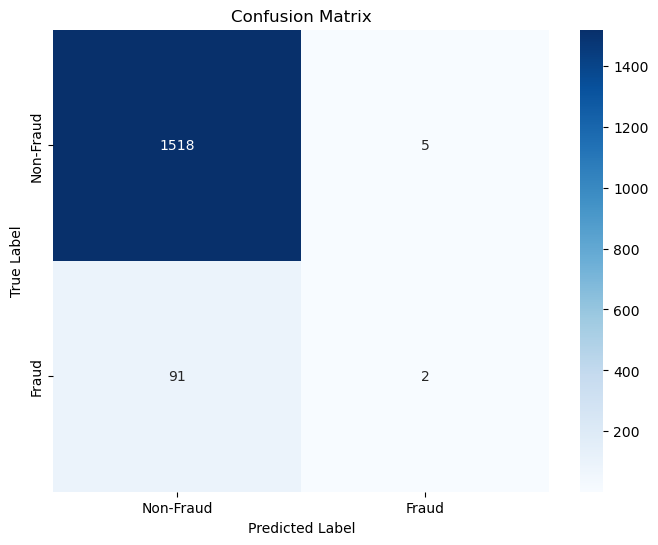

In [54]:
# calculate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)  # use predicted_labels for the confusion matrix

# create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,  
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Make Predictions on the Test Set After Applying PCA Transformation

In this step, we evaluate the performance of the pre-trained Random Forest model on the test set:

### Procedure:

1. **PCA Transformation:**
   - The test images are first flattened and then transformed using the loaded PCA model to match the training data's dimensionality.

2. **Prediction:**
   - The transformed test images are used to obtain:
     - **Predicted Probabilities (`predict_proba`)**: Probabilities for each class (fraud and non-fraud).
     - **Predicted Labels (`predict`)**: Binary classification labels.

3. **Performance Metrics:**
   - **Test Accuracy**: The percentage of correctly classified samples.
   - **Test Loss**: Log loss calculated using the predicted probabilities and true labels.

4. **Visualization:**
   - A horizontal bar chart is created to display:
     - **Test Loss**
     - **Test Accuracy**

### Results:
- **Test Loss:** Computed to measure the model's performance in predicting probabilities.
- **Test Accuracy:** Expressed as a percentage of correctly classified test samples.

The horizontal bar chart highlights these metrics for quick analysis and comparison.

Test Loss: 0.2349
Test Accuracy: 94.06%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


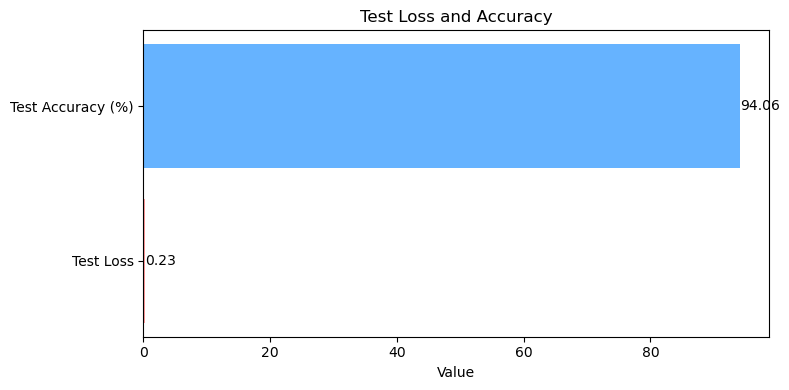

In [56]:
# calculate test accuracy and loss
test_accuracy = accuracy_score(test_labels, predicted_labels)
test_loss = log_loss(test_labels, predicted_probs)

# display the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# data for plotting
metrics = ['Test Loss', 'Test Accuracy (%)']
values = [test_loss, test_accuracy * 100]

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# create the horizontal bar chart
bars = ax.barh(metrics, values, color=['#ff9999', '#66b3ff'])

# set labels and title
ax.set_xlabel('Value')
ax.set_title('Test Loss and Accuracy')

# display the value of each bar on the right
for bar in bars:
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2f}", 
            color='black', va='center', fontsize=10)

# show the plot
plt.tight_layout()
plt.show()

### Evaluation Results
After evaluating the model on the denoised test images, we obtained the following results:
- **Test Loss:** 0.2349
- **Test Accuracy:** 94.06%
Although the model achieves a seemingly high accuracy of 94.25%, this performance is misleading. The accuracy is driven primarily by correctly classifying the majority non-fraud cases, while the model struggles to accurately identify the minority fraud cases, highlighting its limitations in handling class imbalance effectively.

# Calculate and Plot ROC and Precision-Recall Curves

This section evaluates the classification model's performance using the Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves.

### Steps:

1. **Calculate ROC Curve:**
   - Use the `roc_curve` function to compute:
     - **False Positive Rate (FPR):** Proportion of negatives incorrectly identified as positives.
     - **True Positive Rate (TPR):** Proportion of positives correctly identified.
   - Input: 
     - **True Labels (`test_labels`)**
     - **Predicted Probabilities (`predicted_probs[:, 1]`)** for the positive class.

2. **Compute Area Under the Curve (AUC):**
   - The `auc` function computes the area under the ROC curve to summarize performance.

3. **Calculate Precision-Recall Curve:**
   - The `precision_recall_curve` function computes precision and recall values.

4. **Visualize Curves:**
   - **ROC Curve:**
     - Plots TPR vs. FPR.
     - Includes a diagonal line (`y = x`) to represent random guessing.
     - Displays the AUC score in the legend.
   - **Precision-Recall Curve:**
     - Plots Precision vs. Recall to highlight performance for imbalanced datasets.

5. **Purpose:**
   - The ROC curve evaluates the model's ability to distinguish between classes.
   - The PR curve focuses on the balance between precision and recall, especially in imbalanced datasets.

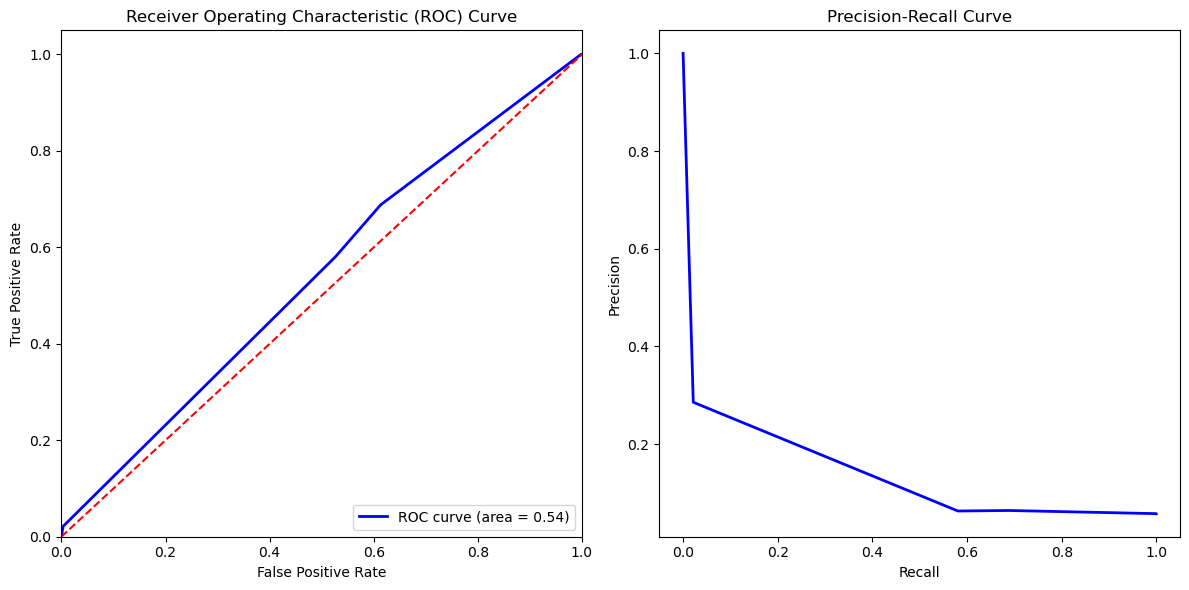

In [58]:
# calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, predicted_probs[:, 1])  # Use predicted_probs for ROC curve (probabilities for the positive class)
roc_auc_value = auc(fpr, tpr)  # Calculate the area under the ROC curve

# calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, predicted_probs[:, 1])  # Use predicted_probs for Precision-Recall curve

# plot ROC curve
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

### Function to Load Unlabeled Validation Images
The below function allows for loading images from validation dataset without requiring labels.

In [60]:
# function to load unlabelled validation images
def load_unalabelled_images_from_directory(directory, label=None):
    images = []
    labels = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_path = os.path.join(root, file)
                image = load_img(image_path, target_size=(128, 128))  # Load image
                image = img_to_array(image)  # Convert to array
                images.append(image)
                
                # Append label if provided
                if label is not None:
                    labels.append(label)
    
    images = np.array(images)
    
    if label is not None:
        labels = np.array(labels)
        return images, labels
    
    return images

In [62]:
# load validation images from the 'sol' directory
val_dir = os.path.join(directory, 'sol')
val_images = load_unalabelled_images_from_directory(val_dir)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named 'sol'.")
else:
    print(f"Validation images loaded successfully. Shape: {val_images.shape}")

Validation images loaded successfully. Shape: (3462, 128, 128, 3)


# Predicting Labels for Validation Images Using Pre-Trained Model

### Procedure:

1. **Flatten Validation Images:**
   - Validation images are reshaped into a 2D array where each row corresponds to a single flattened image.

2. **Load Pre-Trained Model and PCA:**
   - Load the saved Random Forest classification model and PCA transformation from the file `rf_gan_with_pca.pkl`.
   - Ensure successful loading and initialization of both the model and PCA.

3. **PCA Transformation:**
   - Apply PCA to the flattened validation images to reduce dimensionality, matching the training data's input format.

4. **Prediction:**
   - Use the pre-trained classification model to predict binary labels for the validation dataset.

5. **Verification:**
   - Confirm the transformed shape of the validation images and predicted labels.
   - Print the predicted labels for validation.

### Key Outputs:
- **Validation Images Shape (PCA Transformed):** Displays the dimensions of the validation data after PCA transformation.
- **Predicted Validation Labels Shape:** Shows the shape of the predicted label array.
- **Predicted Validation Labels:** Outputs the predicted labels for inspection.

In [63]:
# flatten the validation images for PCA transformation
val_images_flattened = val_images.reshape(val_images.shape[0], -1)  # flatten to shape (num_samples, 128*128*3)

# load the classification model and PCA
model_name = 'rf_gan_with_pca_.pkl'
saved_objects = joblib.load(model_name)  # ensure both model and PCA are loaded
classification_model = saved_objects['rf_classifier']
pca = saved_objects['pca']
print(f"Model '{model_name}' and PCA loaded successfully.")

# transform validation images using the PCA
val_images_pca = pca.transform(val_images_flattened)

# predict labels for validation images
predicted_val_labels = classification_model.predict(val_images_pca)

# verify the shape of the validation images and predicted labels
print(f"Validation Images Shape (PCA Transformed): {val_images_pca.shape}")
print(f"Predicted Validation Labels Shape: {predicted_val_labels.shape}")

# print the predicted labels
print(f"Predicted Validation Labels: {predicted_val_labels}")

Model 'rf_gan_with_pca_.pkl' and PCA loaded successfully.
Validation Images Shape (PCA Transformed): (3462, 200)
Predicted Validation Labels Shape: (3462,)
Predicted Validation Labels: [0. 0. 0. ... 0. 0. 0.]


# Generating Validation Predictions and Label Classification

### Procedure:

1. **Get Image Paths:**
   - A function `get_image_paths_from_directory` is used to traverse a directory and gather all image paths by checking for valid image files.

2. **Generate Validation Predictions:**
   - The `classification_model` is used to predict labels for the validation set (`val_images_pca`).

3. **Create DataFrame for Predictions:**
   - A DataFrame is created to store the image paths alongside their predicted labels.
   - A new column `classified` is added, converting the binary labels (0 for non-fraud, 1 for fraud) into string labels ('non-fraud' or 'fraud').

4. **Print Fraud and Non-Fraud Counts:**
   - The count of 'fraud' and 'non-fraud' predictions is printed, showing how many images are classified under each label.

5. **Export to CSV:**
   - The `val_predictions` DataFrame is exported to a CSV file named `gan_rf_pca_validation_predictions.csv` for further analysis or record-keeping.

### Key Outputs:
- **Fraud Count:** The number of images predicted as fraud.
- **Non-Fraud Count:** The number of images predicted as non-fraud.
- **CSV Exported:** The predictions are saved in `gan_rf_pca_validation_predictions.csv`.

In [64]:
# function to get all image paths in a directory
def get_image_paths_from_directory(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [65]:
# Generate validation predictions
val_labels = classification_model.predict(val_images_pca)  # Ensure this is run before using val_labels

# Create a DataFrame for the validation predictions
val_image_paths = get_image_paths_from_directory(val_dir)  # Replace with actual function to get image paths
val_predictions = pd.DataFrame({'image_path': val_image_paths, 'predicted_label': val_labels})

# Add a column for fraud and non-fraud labels
val_predictions['classified'] = val_predictions['predicted_label'].apply(lambda x: 'fraud' if x == 1 else 'non-fraud')

# Print fraud and non-fraud counts
print('Fraud count:', val_predictions[val_predictions['predicted_label'] == 1].shape[0])
print('Non-Fraud count:', val_predictions[val_predictions['predicted_label'] == 0].shape[0])

Fraud count: 492
Non-Fraud count: 2970


In [66]:
# export to CSV
val_predictions.to_csv('gan_rf_validation_predictions_.csv', index=False)
print("Validation predictions have been exported to gan_rf_pca_validation_predictions_.csv")

Validation predictions have been exported to gan_rf_pca_validation_predictions_.csv


# Image Loading and Visualization

### Image Loading and Preprocessing:
- We define a function to load an image from a given path, resize it to the expected input shape of **128x128** pixels, and normalize the pixel values to the range **[0, 1]**. This ensures that the images are preprocessed and in the correct format for the Random Forest model.

### Visualization of Predictions:
- A function is created to visualize a sample of fraudulent and non-fraudulent images along with their predicted labels. 
- The predictions are filtered to separate fraud and non-fraud images, and a specified number of images are randomly selected from each category.
- The images are then plotted in subplots, with each subplot displaying an image along with its predicted label.

### Displaying the Results:
- The final visualization is generated by calling the plotting function, showing a few selected images from both fraud and non-fraud categories, enabling a qualitative assessment of the model's predictions.

In [72]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your CNN
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

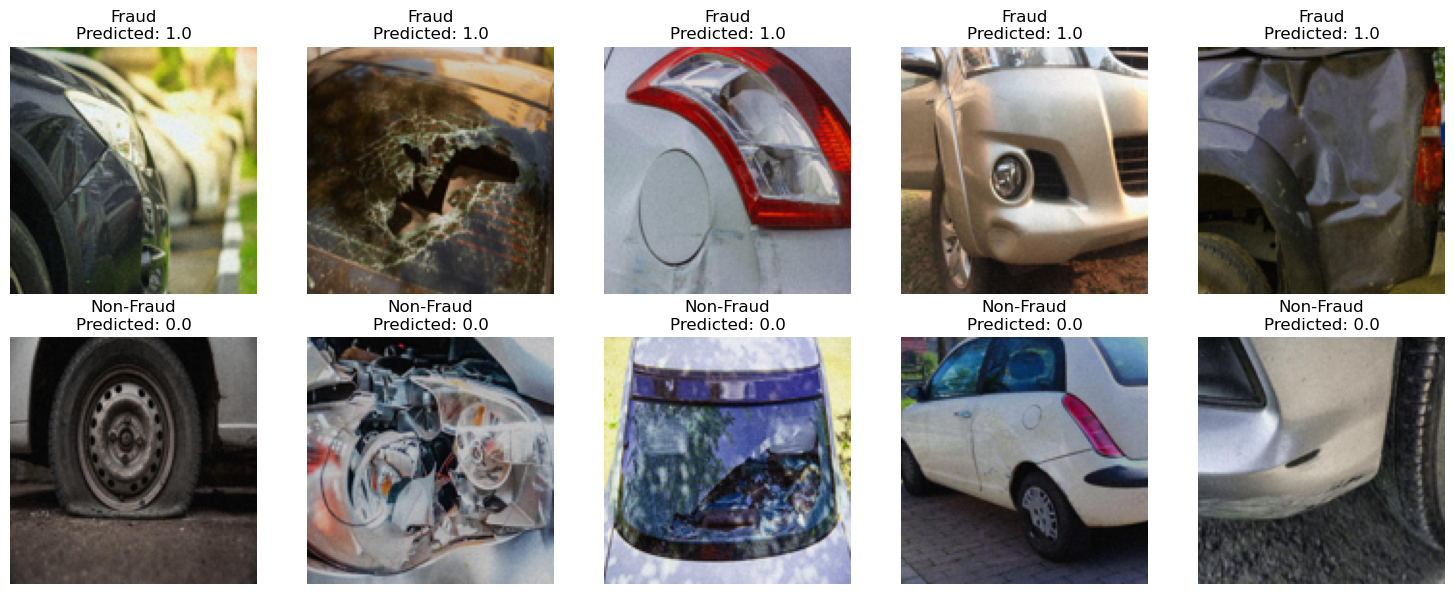

In [74]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions[val_predictions['predicted_label'] == 1]
    non_fraud_images = val_predictions[val_predictions['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
        axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
        axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(val_predictions, n=5)
